# Ames Housing Data EDA

This project aims to predict housing prices in Ames, Iowa based on the Ames Iowa Housing Dataset from the Ames City Assessor's Office, made available by Dean De Cock of Truman University in 2011. Professor De Cock's original paper can be found [here.](http://jse.amstat.org/v19n3/decock.pdf)

Presentation Slides for this project can be found [here.](https://www.beautiful.ai/player/-N4J5UYshyuRtwl5G4I7)

This notebook includes python code for data extraction and cleaning. Preprocessing and feature engineering code as well as Model Fitting and Analysis code can be found in the Feature Engineering and Modeling notebooks, respectively

### Sections and steps

- <a href="#IMP">1. Reading in Data</a><br>
- <a href="#DQ">2. Data Quality</a><br>
    - <a href="#RD">2.1 Removing Duplicates</a><br>
    - <a href="#MD">2.2 Handling Missing Data</a><br>
    - <a href="#OT">2.3 Handling Outliers</a><br>
    - <a href="#SP">2.4 Summary of Data Cleaning </a>
- <a href="#EDA">3. Exploratory Data Analysis</a><br>
    - <a href="#FP">3.1 First Pass - Visualization</a><br>
    - <a href="#SEDA">3.2 Summary of EDA Findings </a>
- <a href="#EXP">4. Exporting Cleaned Dataset</a><br>

<p><a name="IMP"></a></p>

## 1. Importing Packages, Reading in Data

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#helper module
from helper_module import *

#setting options to view dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#warnings
import warnings
warnings.filterwarnings("ignore")

#helper module functionality
%load_ext autoreload
%autoreload 2

In [2]:
#testing to make sure helper module loaded
get_dog()

'Yes! Module loaded successfully! Sorry, no dogs!'

### Helper Functions

In [3]:
def help_missing(title = 'Features with missing values'):
    num_missing = train.isnull().sum().sort_values(ascending = False)
    pct = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
    df_md = pd.concat([num_missing, pct], axis=1, keys=['Number', 'Percent'])
    
    #filtering for only the variables where there is 1 or more missing observations
    df_md.columns
    df_md = df_md.loc[df_md.Number > 0]
    has_missing = df_md['Number']
    
    #Making a chart
    fig, ax = plt.subplots()
    has_missing.plot.bar()
    p = ax.bar(x = has_missing.index, height = has_missing.values) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(top = top*1.05)
    plt.title(title)
    fig = plt.gcf()
    fig.set_size_inches(len(has_missing)/2, 4)
    plt.show()
    return df_md

In [4]:
#reading in train data
train = pd.read_csv('./data/raw/train.csv')
print(f"Read in Ames Housing Train Data - Shape: {train.shape}")

Read in Ames Housing Train Data - Shape: (1460, 81)


In [5]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


<p><a name="DQ"></a></p>

## 2. Data Quality

In [6]:
print('The raw number of features is ', train.shape[1])
print('The raw number of observations is ', train.shape[0])
print('The datattypes are:', train.dtypes.unique())

The raw number of features is  81
The raw number of observations is  1460
The datattypes are: [dtype('int64') dtype('O') dtype('float64')]


In [7]:
#getting a look at column data types
#train.info()

Noticing here categorical values that have numerical dtypes:

        - MSSubClass
        - MoSold

In [8]:
#changing the dtype of these variables to strings
for item in ['MSSubClass', 'MoSold']:
    train[item] = train[item].astype(str)
    print(train[item].dtype)

object
object


In [9]:
#selecting just categorical variables in the dataframe and creating a list
cat_var = train.select_dtypes('O').columns.tolist()

#selecting just continuous variables in the dataframe and creating a list
num_var = train.select_dtypes('number').columns.tolist()
num_var.remove('Id')

print('The number of categorical features is' , len(cat_var))
print('The number of numerical features is', len(num_var))
print('The combined numerical and categorical features are', train.shape[1]-1)

The number of categorical features is 45
The number of numerical features is 35
The combined numerical and categorical features are 80


<p><a name="RD"></a></p>

### 2.1 Removing Duplicates

Reading the original paper that Professor De Cock released with the dataset, he notes that properties sold multiple times in this time frame were only included once (the most recent sale).

There were no duplicates in the original dataset, but since this dataset is a subset, and has been preprocessed, we will still check for duplicates to be thorough.

In [10]:
train[train.Id.duplicated()] #no duplicates found

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


<p><a name="MD"></a></p>

### 2.2 Handling Missing Data

We can see that there are several variables missing some observations.

As per the data description, we will replace empty values that have meanings with the appropriate meaning. Eg. For PoolQC, NA actually means there is no pool on the property

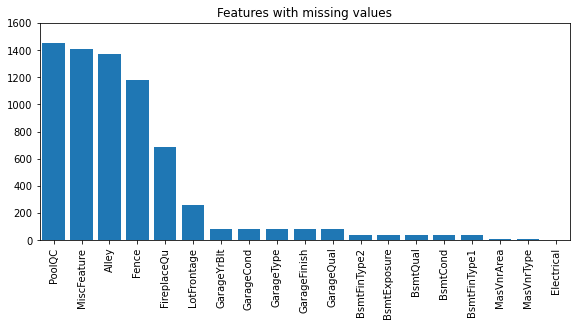

,Number,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [11]:
#using helper function to show us the columns with missing data
help_missing()

In [12]:
# Replacing missing values with appropriate meaning based on data description
train.fillna(value={'Alley' : 'NoAlley',
                   'BsmtQual': 'NoBasement',
                   'BsmtCond': 'NoBasement',
                   'BsmtExposure': 'NoBasement',
                   'BsmtFinType1': 'NoBasement',
                   'BsmtFinType2': 'NoBasement',
                   'FireplaceQu' : 'NoFireplace',
                   'GarageType': 'NoGarage',
                   'GarageFinish': 'NoGarage',
                   'GarageQual': 'NoGarage',
                    'GarageCond' : 'NoGarage',
                   'PoolQC': 'NoPool',
                   'Fence': 'NoFence',
                   'MiscFeature': 'NoMisc'},
            inplace = True)

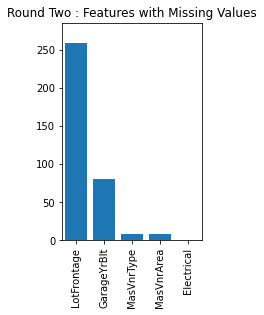

,Number,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685


In [13]:
help_missing('Round Two : Features with Missing Values')

In [14]:
#Looking at MasVnrType, MasVnrArea
#Data description says NA is no MasVnrType
train['MasVnrType'].fillna('None', inplace=True)
#imputing 0 for MasVnrArea
train['MasVnrArea'].fillna(0, inplace=True)

In [15]:
#Looking at Electrical, there is one missing value
#looking at the options
train['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [16]:
#Looking at Electrical value counts
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [17]:
#going to drop the Electrical observation that is missing data
print(train.shape)
train.drop(np.where(train['Electrical'].isna())[0], axis = 0, inplace = True)
train.shape

(1460, 81)


(1459, 81)

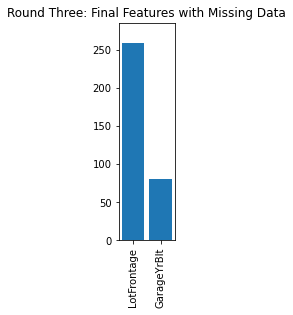

,Number,Percent
LotFrontage,259,0.177519
GarageYrBlt,81,0.055517


In [18]:
help_missing('Round Three: Final Features with Missing Data')

In [19]:
#Looking at Garage Year Built
print(train['GarageYrBlt'].describe())
print('Earliest Garage built was in : ', train['GarageYrBlt'].min())

count    1378.000000
mean     1978.485486
std        24.686740
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
Earliest Garage built was in :  1900.0


In [20]:
#Looking at Garage Year Built side by side with Year House was Built
# converting both years to numerical
train['GarageYrBlt'] = train['GarageYrBlt'].astype(float)
train['YearBuilt'] = train['YearBuilt'].astype(float)
train[['GarageYrBlt', 'YearBuilt']].head(20)

,GarageYrBlt,YearBuilt
0,2003.0,2003.0
1,1976.0,1976.0
2,2001.0,2001.0
3,1998.0,1915.0
4,2000.0,2000.0
5,1993.0,1993.0
6,2004.0,2004.0
7,1973.0,1973.0
8,1931.0,1931.0
9,1939.0,1939.0


In [21]:
#imputing Garage year as year house was built for missing values
train['GarageYrBlt'].fillna(train.YearBuilt, inplace=True)

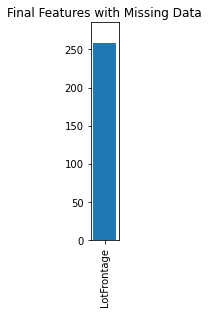

,Number,Percent
LotFrontage,259,0.177519


In [22]:
help_missing('Final Features with Missing Data')

In [23]:
#Looking at LotFrontage
#trying to see if these homes maybe don't have any street
#maybe high density aka condos or apartments?
train[train['LotFrontage'].isnull()]['MSZoning'].value_counts()

RL    229
RM     19
FV      8
RH      3
Name: MSZoning, dtype: int64

In [24]:
#trying again, with type of dwelling
train[train['LotFrontage'].isnull()]['MSSubClass'].value_counts()

20     99
60     69
120    20
80     20
50     16
160     8
85      6
30      6
70      5
90      5
190     3
75      1
40      1
Name: MSSubClass, dtype: int64

In [25]:
#trying again with lot configuration
train[train['LotFrontage'].isnull()]['LotConfig'].value_counts()

Inside     134
Corner      62
CulDSac     49
FR2         14
Name: LotConfig, dtype: int64

<AxesSubplot:xlabel='LotConfig', ylabel='count'>

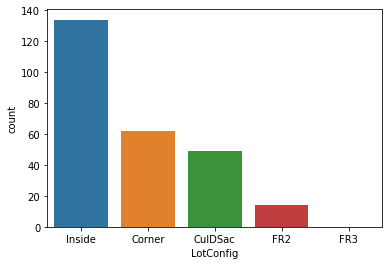

In [26]:
#visualizing with a count plot
sns.countplot(x=train[train['LotFrontage'].isnull()]['LotConfig'],
              data = train[train['LotFrontage'].isnull()],
             order = ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'])

Inside     1051
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


<AxesSubplot:xlabel='LotConfig', ylabel='count'>

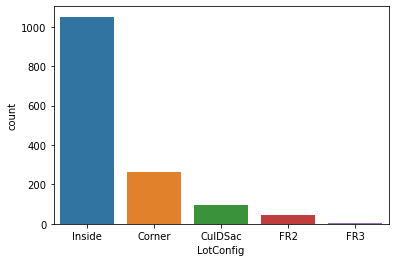

In [27]:
#comparing this with value counts of lot config across dataset
print(train.LotConfig.value_counts())
#visualizing with a count plot
sns.countplot(x=train['LotConfig'],
              data = train,
             order = ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'])

We could impute the missing values of Lot Frontage as the mean or median of the Lot Configuration. It would make sense that different types of Lot configuration might have more or less lot frontage.

Let's take a look at the distributions of Lot Frontage based on Lot Configuration

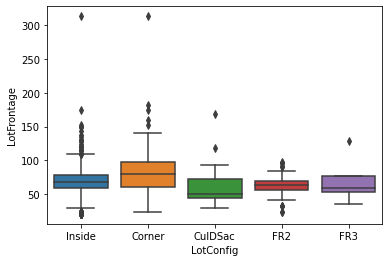

In [28]:
#boxplot of Lot Frontage based on Lot Configuration
sns.boxplot(x='LotConfig',
            y = 'LotFrontage',
            order = ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
            data = train);

Immediately noticing some outliers in Lot Frontage, we will deal with those next.

The box plot shows that the amount of Lot Frontage of each property does change based on Lot Configuration. To be sure, let's run an ANOVA.

In [29]:
#Running an ANOVA to make sure the group means are different
model = ols('LotFrontage ~ C(LotConfig)', data = train).fit()
anova_tbl = sm.stats.anova_lm(model, typ=2)
effect_size = anova_tbl['sum_sq'][0]/(anova_tbl['sum_sq'][0]+anova_tbl['sum_sq'][1])
        
p_val = round(anova_tbl['PR(>F)'][0], 5)
print('ANOVA p-val and effect size for classes of Lot Config is :', p_val, ' and ', round(effect_size, 5))

ANOVA p-val and effect size for classes of Lot Config is : 0.0  and  0.07121


In [30]:
#imputing median values for missing Lot Config values

print(train['LotFrontage'].mean())
print(train['LotFrontage'].median())

#Noticing that the mean and the median for the entire Lot Frontage series are very close

70.0475
69.0


In [31]:
#imputing median LotFrontage value based on each LotConfig group
count = 0
for (idx, LotConfig) in train[train['LotFrontage'].isnull()].iterrows():
    config = train['LotConfig'][idx]
    dict1 = train.groupby(['LotConfig']).median()[['LotFrontage']].to_dict()
    train['LotFrontage'][idx] = dict1['LotFrontage'][config]
    count += 1
print(count)

259


In [32]:
#testing to see if it worked
train['LotFrontage'].isnull().sum()

0

<p><a name="OT"></a></p>

### 2.3 Handling Outliers

In Professor De Cock's original paper, he recommends removing outliers from GrLivArea. We will look at these first:

In [33]:
#Setting a Z-value threshold of 4.0
obs_to_drop = []

z_scores = stats.zscore(train[num_var][['GrLivArea']])
obs_to_drop += np.where(abs(z_scores) > 4.0)[0].tolist()
obs_to_drop

[523, 691, 1169, 1182, 1298]

Creating a dictionary of observations that are outliers for the other numerical variables:

In [34]:
ot_dict = {}
for var in num_var:
    z_scores = stats.zscore(train[num_var][[var]])
    outliers = np.where(abs(z_scores)> 4.0)[0].tolist()
    ot_dict[var] = outliers

In [35]:
ot_dict.keys()

dict_keys(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice'])

Of the features with outliers, taking a deeper look at LotArea, GrLivArea

In [36]:
#Looking at Lot Area Outliers
train['LotArea'].describe()

count      1459.000000
mean      10517.363948
std        9984.666267
min        1300.000000
25%        7549.000000
50%        9477.000000
75%       11603.000000
max      215245.000000
Name: LotArea, dtype: float64

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

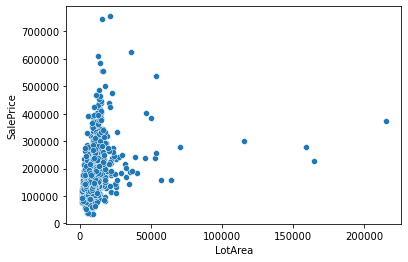

In [37]:
sns.scatterplot(x='LotArea', y = 'SalePrice',
                          data=train)

In [38]:
train.loc[ot_dict['LotArea']]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,50.0,159000,Pave,NoAlley,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958.0,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NoPool,NoFence,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NoAlley,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965.0,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMisc,0,6,2009,WD,Normal,375000
335,336,190,RL,80.0,164660,Grvl,NoAlley,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965.0,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NoPool,NoFence,Shed,700,8,2008,WD,Normal,228950
384,385,60,RL,80.0,53107,Pave,NoAlley,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992.0,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,985,Unf,0,595,1580,GasA,Ex,Y,SBrkr,1079,874,0,1953,1,0,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.0,Fin,2,501,TA,TA,Y,216,231,0,0,0,0,NoPool,NoFence,NoMisc,0,6,2007,WD,Normal,240000
451,452,20,RL,62.0,70761,Pave,NoAlley,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975.0,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,NoPool,NoFence,NoMisc,0,12,2006,WD,Normal,280000
457,458,20,RL,50.0,53227,Pave,NoAlley,IR1,Low,AllPub,CulDSac,Mod,ClearCr,Norm,Norm,1Fam,1Story,4,6,1954.0,1994,Flat,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,1116,Unf,0,248,1364,GasA,Ex,Y,SBrkr,1663,0,0,1663,1,0,1,0,2,1,Gd,6,Min1,2,Gd,Attchd,1954.0,Fin,2,529,TA,TA,Y,224,137,0,0,0,0,NoPool,NoFence,NoMisc,0,3,2008,WD,Normal,256000
706,707,20,RL,50.0,115149,Pave,NoAlley,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971.0,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NoPool,NoFence,NoMisc,0,6,2007,WD,Normal,302000
769,770,60,RL,47.0,53504,Pave,NoAlley,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003.0,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NoPool,NoFence,NoMisc,0,6,2010,WD,Normal,538000
1298,1299,60,RL,313.0,63887,Pave,NoAlley,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008.0,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NoFence,NoMisc,0,1,2008,New,Partial,16

In [39]:
obs_to_drop += ot_dict['LotArea']

In [40]:
#Looking at GrLivArea outliers
train['LotArea'].describe()

count      1459.000000
mean      10517.363948
std        9984.666267
min        1300.000000
25%        7549.000000
50%        9477.000000
75%       11603.000000
max      215245.000000
Name: LotArea, dtype: float64

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

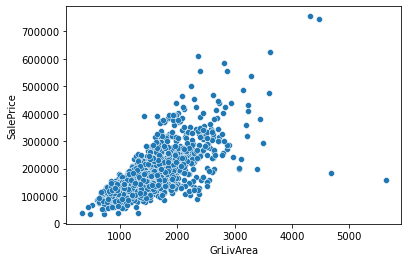

In [41]:
sns.scatterplot(x='GrLivArea', y = 'SalePrice',
                          data=train)

Can clearly see some unusual outliers in GrLivArea

In [42]:
train.loc[ot_dict['GrLivArea']]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NoAlley,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007.0,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NoPool,NoFence,NoMisc,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994.0,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NoPool,NoFence,NoMisc,0,1,2007,WD,Normal,755000
1169,1170,60,RL,118.0,35760,Pave,NoAlley,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995.0,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NoPool,NoFence,NoMisc,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996.0,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NoMisc,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NoAlley,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008.0,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NoFence,NoMisc,0,1,2008,New,Partial,160000


In [43]:
obs_to_drop += ot_dict['GrLivArea']
obs_to_drop += ot_dict['SalePrice']

In [44]:
print(train.shape)
print(set(obs_to_drop))
train.drop(obs_to_drop, axis = 0, inplace = True)
print('Dropped ' , len(set(obs_to_drop)), ' observations.')

(1459, 81)
{384, 769, 898, 523, 1169, 1298, 1046, 1182, 803, 178, 691, 440, 313, 706, 451, 457, 335, 1395, 249}
Dropped  19  observations.


In [45]:
train.shape

(1440, 81)

In [46]:
obs_to_drop = []

<p><a name="SP"></a></p>

### 2.4 Summary of Data Cleaning

##### Observations Dropped (19)
   - Electrical -> 1 obs dropped due to missing data
   - LotArea - > 10 outlier obs dropped 
   - GrLivArea -> 5 outlier obs dropped
   - SalePrice -> 4 outlier obs dropped

<p><a name="EDA"></a></p>

## 3. Exploratory Data Analysis

<p><a name="FP"></a></p>

### 3.1 First Pass - Visualization


#### 3.1.1 Dependant Variable - Sale Price

In [47]:
#descriptive summary of Sale Price
train['SalePrice'].describe()

count      1440.000000
mean     177723.281250
std       71691.729015
min       34900.000000
25%      129500.000000
50%      161875.000000
75%      212000.000000
max      485000.000000
Name: SalePrice, dtype: float64

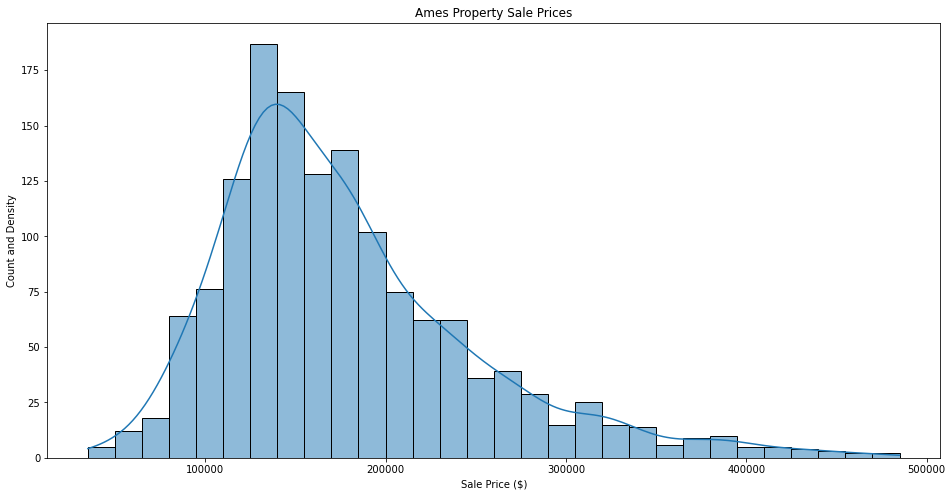

In [48]:
#plotting a histogram using seaborn
#histogram
plt.figure(figsize=(16,8))
sns.histplot(train.SalePrice, bins=30, kde=True)
plt.title("Ames Property Sale Prices")
plt.xlabel("Sale Price ($)")
plt.ylabel("Count and Density")
plt.show()

Noticing that the dependent variable looks right skewed (aka not normally distributed)

In [49]:
#checking Mean and Median
print('Median: %f' % round(train.SalePrice.median()))
print('Mean: %f' % round(train.SalePrice.mean()))
#checking skewness and kurtosis
print("Skewness: %f" % train.SalePrice.skew())
print("Kurtosis: %f" % train.SalePrice.kurt())

Median: 161875.000000
Mean: 177723.000000
Skewness: 1.225079
Kurtosis: 1.814382


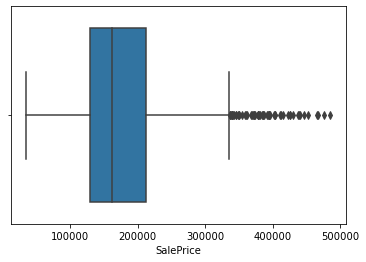

In [50]:
#looking at potential outliers
sns.boxplot(x = train.SalePrice, )
plt.show()

In [51]:
#finding sale price outliers
spoutliers = train[np.abs(stats.zscore(train.SalePrice)) > 4]
spoutliers.sort_values('SalePrice')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1243,1244,20,RL,107.0,13891,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006.0,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,NoPool,NoFence,NoMisc,0,9,2006,New,Partial,465000
1373,1374,20,RL,68.0,11400,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,10,5,2001.0,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,705.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1282,Unf,0,1351,2633,GasA,Ex,Y,SBrkr,2633,0,0,2633,1,0,2,1,2,1,Ex,8,Typ,2,Gd,Attchd,2001.0,RFn,3,804,TA,TA,Y,314,140,0,0,0,0,NoPool,NoFence,NoMisc,0,3,2007,WD,Normal,466500
185,186,75,RM,90.0,22950,Pave,NoAlley,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892.0,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NoPool,GdPrv,NoMisc,0,6,2006,WD,Normal,475000
798,799,60,RL,104.0,13518,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008.0,2009,Hip,CompShg,VinylSd,VinylSd,Stone,860.0,Ex,TA,PConc,Ex,TA,No,Unf,0,Unf,0,1926,1926,GasA,Ex,Y,SBrkr,1966,1174,0,3140,0,0,3,1,4,1,Ex,11,Typ,2,Gd,BuiltIn,2009.0,Fin,3,820,TA,TA,Y,144,78,0,0,0,0,NoPool,NoFence,NoMisc,0,7,2009,New,Partial,485000


Noticing that there are only expensive property outliers in this dataset.

To ensure that the residuals of a linear model taken will be normal, we will take the log of the Sale Price instead of the Sale Price.

In [52]:
#adding a column for log sale price
train['log_SalePrice'] = np.log(train['SalePrice'])

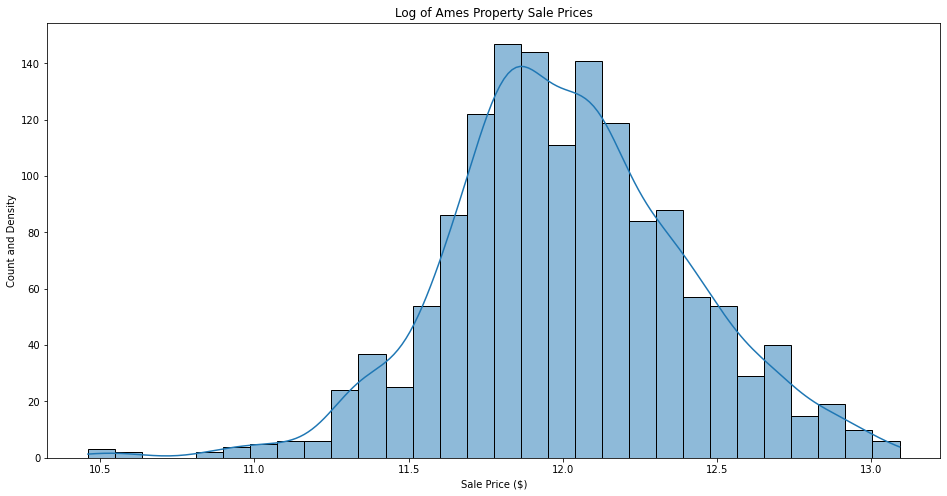

In [53]:
#plotting a histogram using seaborn
#histogram
plt.figure(figsize=(16,8))
sns.histplot(train.log_SalePrice, bins=30, kde=True)
plt.title("Log of Ames Property Sale Prices")
plt.xlabel("Sale Price ($)")
plt.ylabel("Count and Density")
plt.show()

In [54]:
#checking Mean and Median
print('Median: %f' % round(train.log_SalePrice.median()))
print('Mean: %f' % round(train.log_SalePrice.mean()))
#checking skewness and kurtosis
print("Skewness: %f" % train.log_SalePrice.skew())
print("Kurtosis: %f" % train.log_SalePrice.kurt())

Median: 12.000000
Mean: 12.000000
Skewness: -0.032557
Kurtosis: 0.541923


Much better!

Let's look at outliers for this new distribution

In [57]:
lg_spoutliers = train[np.abs(stats.zscore(train.log_SalePrice)) > 4]
lg_spoutliers.sort_values('log_SalePrice')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_SalePrice
916,917,20,C (all),50.0,9000,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949.0,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,TA,N,FuseA,480,0,0,480,1,0,0,0,1,1,TA,4,Typ,0,NoFireplace,Detchd,1958.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NoPool,NoFence,NoMisc,0,10,2006,WD,Abnorml,35311,10.47195


Much Better!

In [56]:
#Dropping the above outlier, which is an abnormal sale
train.drop(495, axis = 0, inplace = True)

In [122]:
train.shape

(1439, 82)

### 3.1.2 Independent Variables
##### Categorical
To get a sense of the independent variables in this dataset, we'll use a helper function to iterate through each categorical variable and look at:
- percentage of missing data
- value counts of observations
- anomalies and outliers
- distribution of variables via barplot and boxplot

Changes to be made will be noted for feature engineering and feature selection.

In [60]:
#using helper function
view_cat = look_cat(cat_var)

In [109]:
#Rerun this cell to see the first pass look at the next categorical variable
#49 total runs
next(view_cat)

StopIteration: 

###### First Pass Categorical Variable Findings
1. Variables that are candidates for further ANOVA and potential condensing
    - MSSubClass -> 
    - LandContour -> could be binarized, very small effect size
    - Lot Config -> mostly inside, but culdesac has mean higher log sp
    - Neighborhood -> high effect size, but too many categories
    - BldgType -> mostly one fam
    - Roof Style - > mostly gable
    - RoofMatl -> mostly compshngl
    - Exterior1st
    - Exterior2nd
    - ExterCond
    - Functional -> mostly typical, but some major
    - SaleCondition -> drop Abnormal/Family/Alloca/AdjLand and only keep normal and partial (new) sales?
3. Variables that are candidates to be dropped
    - Street -> all but 6 observations are in the same category
    - Alley -> only 91 homes with Alley
    - Utilities -> all but one have all public utilities, pval is insig
    - LandSlope -> insig ANOVA
    - BsmtFinType2 -> insig ANOVA
    - PoolQC -> maybe convert to has pool or not (missing 99.52%)
    - Fence -> maybe convert to has fence and not (missing 80%)
    - MiscFeature -> most missing, high p val (missing 96%)
4. Variables to be adjusted
    - MSZoning -> remove 10 obs that are commercial
    - Condition 1 -> maybe split into normal, pos and negative condition
    - Same for Condition 2 -> possible to drop, all but 15 obs are normal
    - House Style -> maybe create 2nd floor or not variable
    - Heating -> maybe split into GasA and other
    - Electrical -> maybe split into Sbrkr and other
    - Paved -> Paved and Not Paved
5. Variables to keep (high effect sizes)
    - MasVnrType
    - ExterQual
    - Foundation
    - BsmtQual
    - BsmtExposure
    - BsmtFinType1
    - HeatingQC
    - CentralAir
    - Kitchen Qual
    - FireplaceQu
    - GarageType
    - GarageFinish
    - SaleType
6. Other Notes
    - LotShape -> interestingly the moderately irregular obs have slightly higher mean sale price
    - MoSold -> highest frequencies in summer months, but not much price diff by month


##### Numerical
To get a sense of the idependent variables in this dataset, we'll use a helper function to iterate through each categorical variable and look at:
- missing data
- anomalies and outliers
- pearson's correlation with dependent variable
- distribution via histogram and scatterplot

Then we'll look at multicollinearity between the numerical variables

Changes to be made will be noted for feature engineering and feature selection.

In [153]:
view_num = look_num(num_var)

In [148]:
#Making sure there are no NANs
#train[num_var].isnull().sum()

In [189]:
#Rerun this cell to see the first pass of the next numerical variable
#31 runs
next(view_num)

StopIteration: 

###### First Pass Numerical Variable Findings
1. Variables that are candidates for further ANOVA and potential condensing
  
3. Variables that are candidates to be dropped
    - BsmtFinSF2 (r of -0.003)
    - LowQualFinSF
    - 3SsnPorch (r = 0.06)
    - PoolArea(r = 0.043)
    - MiscVal (r = -0.02)
4. Variables to be adjusted
    - LotFrontage has two potential outliers (lot frontage > 300)
    - Lot Area has some outliers too (lot area > 40000)
    - OverallQual, Overall Cond, YrSold, should be ordinal variables
    - MasVnrArea has a potential outlier
5. Variables to keep (high effect sizes)
    - LotFrontage
    - LotArea
    - OverallQual
    - Year Built
    - Year RemodAdd
    - MasVnrArea
    - BsmtFinSF1
    - BsmtUnfSF
    - Total BsmtSF
    - 1stFlrSF
    - 2ndFlrSF
    - GrLivArea
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageYrBlt
    - GarageCars
    - GarageArea
    - WoodDeckSF
    - OpenPorchSF
6. Other Notes

#### Looking into Multicollinearity among Features

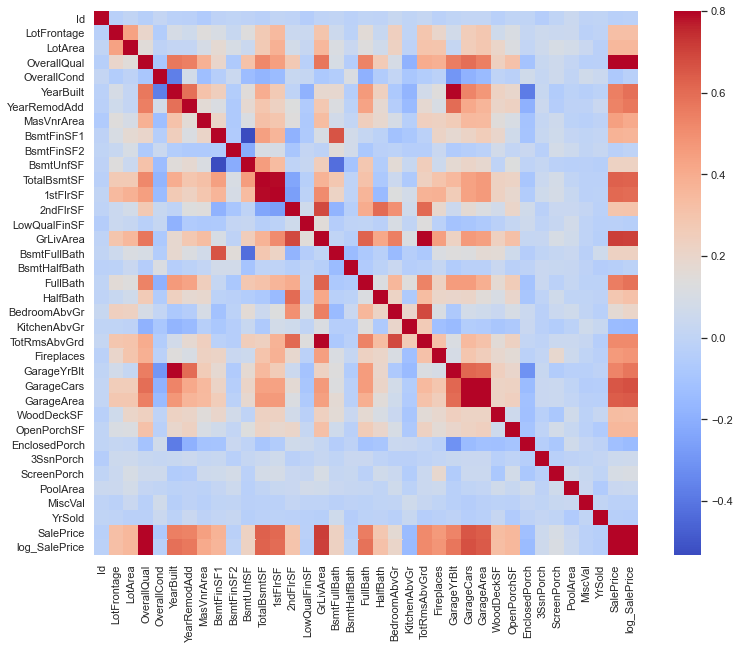

In [191]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat, vmax=.8, cmap = 'coolwarm', square=True);

Multicollinear Feature Pairs observed:
1. TotalBsmtSF <> 1stFlrSF
2. GarageCars <> GarageArea
3. YearBuilt <> GarageYrBlt
4. GrLivArea <> TotRmsAbvGrd

All these pairs make intuitive sense. We will need to drop or change one feature in each pair before using linear models.

Features with strong correlation with log_SalePrice:
1. OverallQual
2. GrLivArea
3. YearBuilt
4. YearRemodAdd
5. TotalBsmtSF
6. 1stFlrSF
7. GarageCars
8. GarageArea
9. FullBath

Taking a closer look

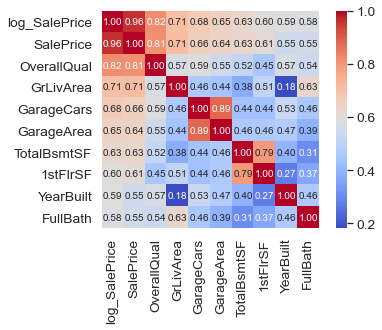

In [195]:
#log_saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap = 'coolwarm', cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

GarageCars is slightly more correlated to log_SalePrice, so we will drop GarageArea.

<p><a name="SEDA"></a></p>

### 3.2 Summary of EDA Findings 




# Testing Below this

In [ ]:
def get_outliers(num_var):
    ot_dict = {}
    for var in num_var:
        z_scores = stats.zscore(train[num_var][[var]])
        outliers = np.where(abs(z_scores)> 4.0)[0].tolist()
        ot_dict[var] = outliers
    return ot_dict.keys()

In [119]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def look_cat(varlist):
    for var in varlist:
        
        #info about missingness and value counts
        num_miss = train[var].isnull().sum()
        pct_miss = round(num_miss/train.shape[0]*100, 2)
        print(var + ' has ' + str(num_miss) + ' missing observations, equal to ' + str(pct_miss) + '%')
        print(train[var].value_counts())
        print('*'*50)
        
        #ANOVA
        temp_ = 'log_SalePrice ~ C(' + var + ')'
        model = ols(temp_, data = train).fit()
        anova_tbl = sm.stats.anova_lm(model, typ=2)
        effect_size = anova_tbl['sum_sq'][0]/(anova_tbl['sum_sq'][0]+anova_tbl['sum_sq'][1])
        p_val = round(anova_tbl['PR(>F)'][0], 5)
        print('ANOVA p-val and effect size for categories of ' + item + ' is', p_val, ' and ', round(effect_size, 5))
        print('*'*50)
        
        #Figures
        sns.set_theme(style="whitegrid", palette = 'husl')
        med = data.groupby([var])['log_SalePrice'].median().sort_values(ascending = False).reset_index()
        
        #seaborn Count Plot
        f, ax = plt.subplots(1, 2, figsize = (10,6))
        sns.countplot(x=train[var], data=train, order = list(med[var]), ax = ax[0])
        plt.xticks(rotation=45)
        #fig1.set(xlabel = var, ylabel = 'Count')
        sns.boxplot(x=var, y = 'log_SalePrice', order = list(med[var]), data=train, ax = ax[1])
        plt.xticks(rotation=45)
        #f.set(xlabel=var, ylabel='Log of Sale Price')
        
        yield f.show()

In [142]:
view_num = look_num(num_var)

In [143]:
next(view_num)

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64
**************************************************


ValueError: array must not contain infs or NaNs

In [141]:
train[num_var].dtypes

LotFrontage      int32
LotArea          int64
OverallQual      int64
OverallCond      int64
YearBuilt        int32
YearRemodAdd     int64
MasVnrArea       int32
BsmtFinSF1       int64
BsmtFinSF2       int64
BsmtUnfSF        int64
TotalBsmtSF      int64
1stFlrSF         int64
2ndFlrSF         int64
LowQualFinSF     int64
GrLivArea        int64
BsmtFullBath     int64
BsmtHalfBath     int64
FullBath         int64
HalfBath         int64
BedroomAbvGr     int64
KitchenAbvGr     int64
TotRmsAbvGrd     int64
Fireplaces       int64
GarageYrBlt      int32
GarageCars       int64
GarageArea       int64
WoodDeckSF       int64
OpenPorchSF      int64
EnclosedPorch    int64
3SsnPorch        int64
ScreenPorch      int64
PoolArea         int64
MiscVal          int64
YrSold           int64
SalePrice        int64
dtype: object

In [140]:
train['LotFrontage'] = train['LotFrontage'].astype(int)

In [ ]:
np.isnan(xx).any()
np.isnan(yy).any()

np.isinf(xx).any()
np.isinf(yy).any()
If any of those yields true. Remove the nan entries or inf entries. E.g. you can set them to 0 with:

xx = np.nan_to_num(xx)
yy = np.nan_to_num(yy)

In [144]:
def look_num(varlist):
    for var in varlist:
        
        #info about missingness
        num_miss = train[var].isnull().sum()
        pct_miss = round(num_miss/train.shape[0]*100, 2)
        print(train[var].describe())
        print('*'*50)
            
        #info about pearson's correlation
        corr = pearsonr(train[var], train['log_SalePrice'])
        print('Pearsons correlation (r):', round(corr[0],3))
        print('*'*50)
        
        #Figures
        sns.set_theme(style="whitegrid")

        #seaborn Histogram
        f, ax = plt.subplots(1, 2, figsize = (10,6))
        sns.histplot(x=var, data=train, ax = ax[0])
        #f.set(xlabel = var, ylabel = 'Count')
        plt.xticks(rotation = 45)
        
        #seaborn Scatterplot
        sns.scatterplot(x=var, y = 'log_SalePrice', data=train, ax = ax[1])
        plt.xticks(rotation=45)
        
        yield f.show()

In [145]:
view_num = look_num(num_var)

count    1439.000000
mean       69.126477
std        21.205678
min        21.000000
25%        60.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64
**************************************************
Pearsons correlation (r): 0.326
**************************************************


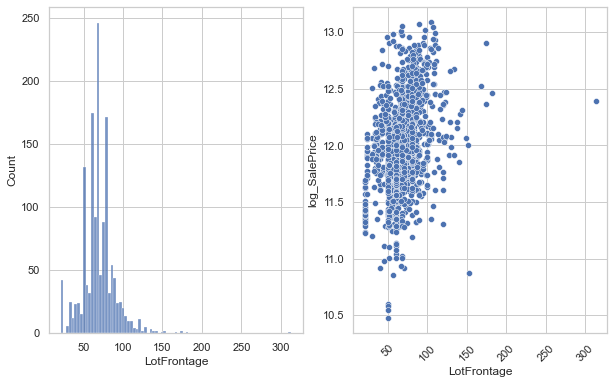

In [146]:
next(view_num)